In [2]:
import math
import random
import itertools

import numpy as np
import pandas as pd

import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from scipy.signal import resample

# fastai 1.0
from fastai import *
from fastai.vision import *
from torchvision.models import *   

import pydicom as pyd
import re
import cv2

In /home/jfang/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/jfang/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/jfang/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
SEED = 300
seed_everything(SEED)

In [4]:
work_dir = '../../../../data/rsna'

In [5]:
label_file = pd.read_csv(f"{work_dir}/stage_2_detailed_class_info.csv")

In [6]:
label_file

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity


In [7]:
label_file.drop_duplicates(subset ="patientId", keep = 'first', inplace = True) 

In [18]:
label_file['class'].value_counts()

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

In [8]:
label_file

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
...,...,...
30219,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal


In [9]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    ds = pyd.read_file(path).pixel_array
    # We flip it to rgb for visualization purposes
    ds = cv2.resize(ds, dsize=(256,256), interpolation=cv2.INTER_CUBIC)
    ds = cv2.cvtColor(ds,cv2.COLOR_GRAY2RGB)
    return ds

In [10]:
train_path = f'{work_dir}/stage_2_train_images'

Text(0, 0.5, 'Other Abnormal')

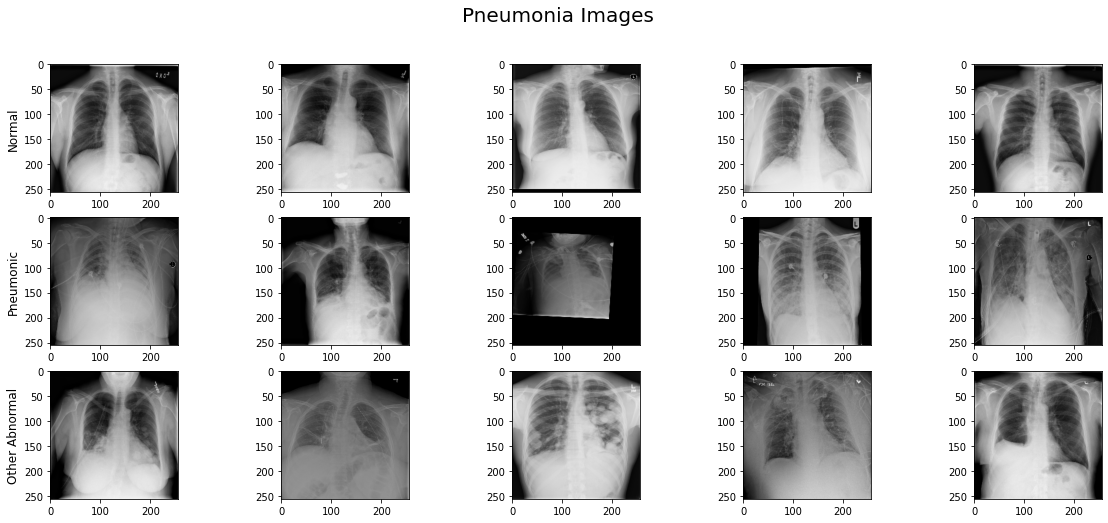

In [11]:
# random sampling

fig, ax = plt.subplots(3,5, figsize=(20,8))
fig.suptitle('Pneumonia Images',fontsize=20)
# Normal
for i, idx in enumerate(label_file[label_file['class'] == 'Normal']['patientId'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.dcm'))
ax[0,0].set_ylabel('Normal', size='large')

# Pneumonic
for i, idx in enumerate(label_file[label_file['class'] == 'Lung Opacity']['patientId'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.dcm'))
ax[1,0].set_ylabel('Pneumonic', size='large')

# Other Abnormalities
for i, idx in enumerate(label_file[label_file['class'] == 'No Lung Opacity / Not Normal']['patientId'][:5]):
    path = os.path.join(train_path, idx)
    ax[2,i].imshow(readImage(path + '.dcm'))
ax[2,0].set_ylabel('Other Abnormal', size='large')

In [12]:
val_idx = random.sample(range(26684),2500)
val_idx[0:25]

[19585,
 11679,
 11295,
 48,
 16073,
 11352,
 17334,
 13875,
 18747,
 18999,
 5430,
 5298,
 3997,
 14013,
 10869,
 12065,
 18713,
 4540,
 20696,
 8072,
 3090,
 19588,
 16475,
 25350,
 16882]

In [13]:
! ls ../../../../data/rsna/

'GCP Credits Request Link - RSNA.txt'   stage_2_train_images
 saved-models			        stage_2_train_labels.csv
 stage_2_detailed_class_info.csv        train-jpg
 stage_2_sample_submission.csv	        train-jpg2
 stage_2_test_images


In [14]:
id_list = list(label_file.patientId)
for i in tqdm_notebook(id_list):
    img = readImage(f'{work_dir}/stage_2_train_images/{i}.dcm')
    cv2.imwrite(f'{work_dir}/train-jpg2/{i}.jpg', img)

/home/jfang/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


KeyboardInterrupt: 

In [7]:
from efficientnet_pytorch import EfficientNet

In [8]:
def getEfficientNet(model_name,pretrained=True):
    """Constructs a EfficientNet model for FastAI.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = EfficientNet.from_name(model_name, override_params={'num_classes':3})

    if pretrained:
        model_state = torch.load(model_path)
        # load original weights apart from its head
        if '_fc.weight' in model_state.keys():
            model_state.pop('_fc.weight')
            model_state.pop('_fc.bias')
            res = model.load_state_dict(model_state, strict=False)
            assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
        else:
            # A basic remapping is required
            from collections import OrderedDict
            mapping = { i:o for i,o in zip(model_state.keys(), model.state_dict().keys()) }
            mapped_model_state = OrderedDict([
                (mapping[k], v) for k,v in model_state.items() if not mapping[k].startswith('_fc')
            ])
            res = model.load_state_dict(mapped_model_state, strict=False)
            print(res)
    return model

In [39]:
model_path = '/home/jfang/.cache/torch/checkpoints/efficientnet-b4-6ed6700e.pth'
arch = getEfficientNet('efficientnet-b4')    

In [17]:
class PixelList(ImageList):
    def open(self, fn:PathOrStr)->Image:
        img = readCroppedImage(fn)
        return vision.Image(px=pil2tensor(img, np.float32))

In [19]:
imgDataBunch = (ImageList.from_df(path=f'{work_dir}/train-jpg2', df=label_file, suffix='.jpg')
        .split_by_idx(val_idx)
        .label_from_df(cols='class')
        .transform(tfms=get_transforms(), size=224)
        .databunch(bs=32)
        .normalize()
       )

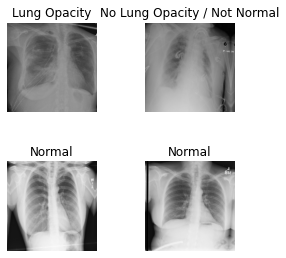

In [20]:
imgDataBunch.show_batch(rows=2, figsize=(4,4))

In [21]:
def getLearner():
    return Learner(imgDataBunch, arch,
                      metrics=error_rate, callback_fns=ShowGraph).to_fp16()

learner = getLearner()

In [22]:
learner.split(lambda m: (arch._conv_head,))
learner.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


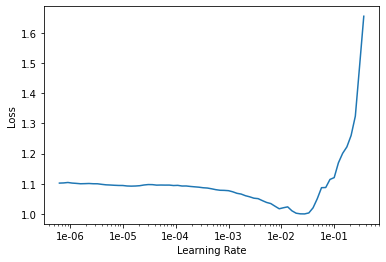

In [23]:
wd = 1e-1
learner.lr_find(wd=wd)
learner.recorder.plot()

In [24]:
max_lr = 7e-3

epoch,train_loss,valid_loss,error_rate,time
0,0.744286,0.919697,0.360000,02:59
1,0.713298,0.952782,0.516000,03:00
2,0.671435,0.832612,0.468800,03:00
3,0.673471,1.271088,0.654800,03:01
4,0.652937,0.958650,0.488800,03:00
5,0.630221,0.744531,0.362000,03:00
6,0.618725,0.575634,0.259200,03:01
7,0.572527,0.566549,0.258400,03:00


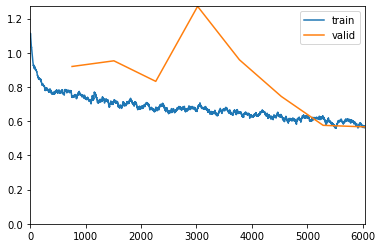

In [25]:
learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)

In [26]:
interp = ClassificationInterpretation.from_learner(learner)

losses,idxs = interp.top_losses()

len(imgDataBunch.valid_ds)==len(losses)==len(idxs)

True

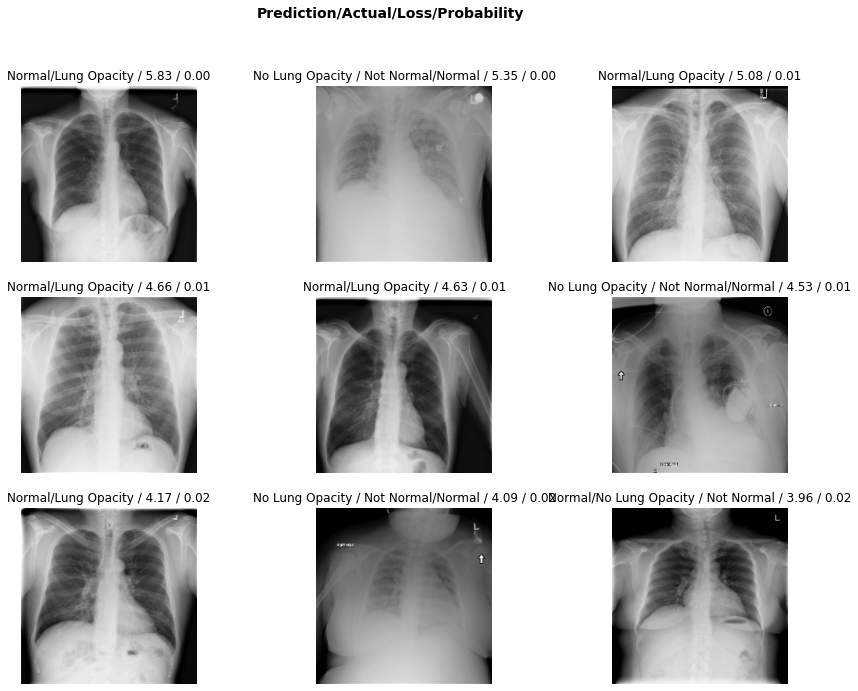

In [27]:
interp.plot_top_losses(9, figsize=(15,11))

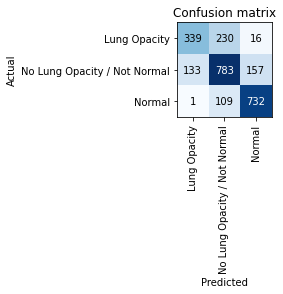

In [28]:
interp.plot_confusion_matrix()

In [29]:
interp.most_confused(min_val=2)

[('Lung Opacity', 'No Lung Opacity / Not Normal', 230),
 ('No Lung Opacity / Not Normal', 'Normal', 157),
 ('No Lung Opacity / Not Normal', 'Lung Opacity', 133),
 ('Normal', 'No Lung Opacity / Not Normal', 109),
 ('Lung Opacity', 'Normal', 16)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


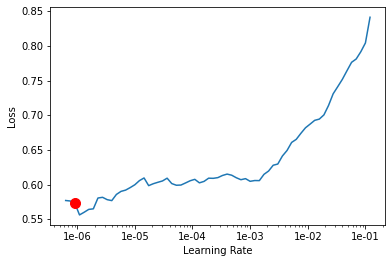

In [30]:
learner.unfreeze()
learner.lr_find(wd=wd)

learner.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,error_rate,time
0,0.600351,0.589169,0.256000,04:17
1,0.593328,0.633418,0.273200,04:17
2,0.569515,0.569409,0.256400,04:18
3,0.556921,0.557347,0.246800,04:21


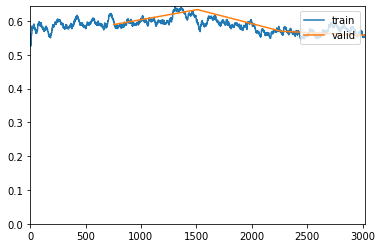

In [31]:
learner.fit_one_cycle(cyc_len=4, max_lr=slice(9e-4))

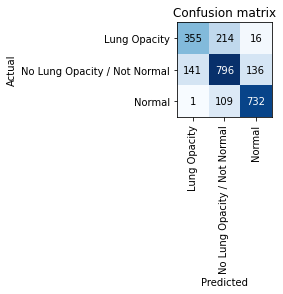

In [32]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

In [33]:
learner.save(f'/home/jfang/fastai/data/rsna/saved-models/model_1', return_path = True)

PosixPath('/home/jfang/fastai/data/rsna/saved-models/model_1.pth')

In [10]:
work_dir2 = '../../../../data/covid-19'

In [11]:
import os
os.listdir(work_dir2)

['saved-models', 'chest_xray', 'covid-chestxray-dataset-master']

In [12]:
os.listdir(work_dir2+'/covid-chestxray-dataset-master')

['.gitignore',
 'README.md',
 'images',
 'metadata.csv',
 'CONTRIBUTING.md',
 'docs']

In [13]:
new_data = pd.read_csv(f'{work_dir2}/covid-chestxray-dataset-master/metadata.csv')

In [14]:
new_data.drop(['doi', 'clinical notes', 'other notes', 'Unnamed: 16', 'survival', 'date', 'location', 'offset', 'sex','license', 'age'], axis = 1, inplace = True)

In [15]:
new_data = new_data[new_data.modality == 'X-ray']
new_data

,Patientid,finding,view,modality,filename,url
0,2,COVID-19,PA,X-ray,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
1,2,COVID-19,PA,X-ray,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
2,2,COVID-19,PA,X-ray,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
3,2,COVID-19,PA,X-ray,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
4,4,COVID-19,PA,X-ray,nejmc2001573_f1a.jpeg,https://www.nejm.org/doi/full/10.1056/NEJMc200...
...,...,...,...,...,...,...
141,72,COVID-19,AP Supine,X-ray,7EF28E12-F628-4BEC-A8C5-E6277C2E4F60.png,https://www.sirm.org/2020/03/16/covid-19-caso-50/
142,73,COVID-19,PA,X-ray,41591_2020_819_Fig1_HTML.webp-day5.png,https://www.nature.com/articles/s41591-020-0819-2
143,73,COVID-19,PA,X-ray,41591_2020_819_Fig1_HTML.webp-day10.png,https://www.nature.com/articles/s41591-020-0819-2
144,74,COVID-19,AP,X-ray,5e6dd879fde9502400e58b2f.jpeg,https://app.figure1.com/rd/images/5e6dd879fde9...


In [16]:
new_data['view'].value_counts()

PA           92
L            11
AP Supine    10
AP           10
Name: view, dtype: int64

In [17]:
new_data = new_data[new_data.view != 'L']
new_data

,Patientid,finding,view,modality,filename,url
0,2,COVID-19,PA,X-ray,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
1,2,COVID-19,PA,X-ray,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
2,2,COVID-19,PA,X-ray,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
3,2,COVID-19,PA,X-ray,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
4,4,COVID-19,PA,X-ray,nejmc2001573_f1a.jpeg,https://www.nejm.org/doi/full/10.1056/NEJMc200...
...,...,...,...,...,...,...
141,72,COVID-19,AP Supine,X-ray,7EF28E12-F628-4BEC-A8C5-E6277C2E4F60.png,https://www.sirm.org/2020/03/16/covid-19-caso-50/
142,73,COVID-19,PA,X-ray,41591_2020_819_Fig1_HTML.webp-day5.png,https://www.nature.com/articles/s41591-020-0819-2
143,73,COVID-19,PA,X-ray,41591_2020_819_Fig1_HTML.webp-day10.png,https://www.nature.com/articles/s41591-020-0819-2
144,74,COVID-19,AP,X-ray,5e6dd879fde9502400e58b2f.jpeg,https://app.figure1.com/rd/images/5e6dd879fde9...


In [18]:
new_data['finding'].value_counts()

COVID-19         89
SARS             11
Streptococcus     6
ARDS              4
No Finding        1
Pneumocystis      1
Name: finding, dtype: int64

In [19]:
new_data = new_data[new_data.finding.isin(['COVID-19','SARS'])]

In [20]:
new_data.reset_index(drop=True, inplace=True)

In [21]:
new_data

,Patientid,finding,view,modality,filename,url
0,2,COVID-19,PA,X-ray,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
1,2,COVID-19,PA,X-ray,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
2,2,COVID-19,PA,X-ray,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
3,2,COVID-19,PA,X-ray,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
4,4,COVID-19,PA,X-ray,nejmc2001573_f1a.jpeg,https://www.nejm.org/doi/full/10.1056/NEJMc200...
...,...,...,...,...,...,...
95,72,COVID-19,AP Supine,X-ray,7EF28E12-F628-4BEC-A8C5-E6277C2E4F60.png,https://www.sirm.org/2020/03/16/covid-19-caso-50/
96,73,COVID-19,PA,X-ray,41591_2020_819_Fig1_HTML.webp-day5.png,https://www.nature.com/articles/s41591-020-0819-2
97,73,COVID-19,PA,X-ray,41591_2020_819_Fig1_HTML.webp-day10.png,https://www.nature.com/articles/s41591-020-0819-2
98,74,COVID-19,AP,X-ray,5e6dd879fde9502400e58b2f.jpeg,https://app.figure1.com/rd/images/5e6dd879fde9...


In [22]:
i = 1
for name in list(map(str,list(new_data.Patientid))):
    if not name.startswith('_'):
        if i < 5:
            print(name, end=(10-len(name))*' ')
            i+=1
        else:
            print(name)
            i = 1

2         2         2         2         4
4         6         6         3         3
3         7         7         8         9
9         10        10        10        11
12        13        13        13        13
14        15        15        15        16
17        17        17        18        19
19        19        19        20        21
22        23        24        32        33
34        35        36        36        37
37        39        40        41        42
43        44        45        46        47
48        49        50        51        51
52        53        54        55        56
57        57        58        58        58
59        59        60        61        62
62        63        64        65        67
67        68        68        69        69
70        70        71        71        71
72        73        73        74        75


In [23]:
extlist = list(map(lambda x: x.split('.')[-1], list(new_data.filename)))

In [24]:
from collections import Counter

print(list(Counter(extlist).keys()))
print(list(Counter(extlist).values())) 

['jpeg', 'jpg', 'png']
[60, 28, 12]


In [25]:
cutpoint = list(filter(lambda x: list(new_data.Patientid)[x] != list(new_data.Patientid)[x+1]
                ,range(0,len(list(new_data.Patientid))-1)))
    

In [26]:
i = 1
for name in list(map(str,[j+1 for j in cutpoint])):
    if not name.startswith('_'):
        if i < 5:
            print(name, end=(10-len(name))*' ')
            i+=1
        else:
            print(name)
            i=1

4         6         8         11        13
14        16        19        20        21
25        26        29        30        33
34        38        39        40        41
42        43        44        45        46
47        49        51        52        53
54        55        56        57        58
59        60        61        62        63
65        66        67        68        69
70        72        75        77        78
79        81        82        83        84
86        88        90        92        95
96        98        99        

In [27]:
cov_filelist = list(new_data.filename)

In [28]:
#os.makedirs(f"{work_dir2}/chest_xray/train/COVID&SARS")
#os.makedirs(f"{work_dir2}/chest_xray/test/COVID&SARS")

In [29]:
os.listdir(f'{work_dir2}/covid-chestxray-dataset-master')

['.gitignore',
 'README.md',
 'images',
 'metadata.csv',
 'CONTRIBUTING.md',
 'docs']

In [30]:
import shutil

In [31]:
'''
for fn in cov_filelist[:86]:
    shutil.copy(f'{work_dir2}/covid-chestxray-dataset-master/images/{fn}',
                f"{work_dir2}/chest_xray/train/COVID&SARS")
'''

'\nfor fn in cov_filelist[:86]:\n    shutil.copy(f\'{work_dir2}/covid-chestxray-dataset-master/images/{fn}\',\n                f"{work_dir2}/chest_xray/train/COVID&SARS")\n'

In [32]:
'''
for fn in cov_filelist[86:]:
    shutil.copy(f'{work_dir2}/covid-chestxray-dataset-master/images/{fn}',
                f"{work_dir2}/chest_xray/test/COVID&SARS")
'''

'\nfor fn in cov_filelist[86:]:\n    shutil.copy(f\'{work_dir2}/covid-chestxray-dataset-master/images/{fn}\',\n                f"{work_dir2}/chest_xray/test/COVID&SARS")\n'

In [33]:
!ls ../../../../data/covid-19/chest_xray

models	train  valid


In [34]:
newImgDataBunch = (ImageDataBunch.from_folder(path=f'{work_dir2}/chest_xray', 
                                              size=224, 
                                              bs=32, 
                                              ds_tfms=get_transforms())

                  .normalize())

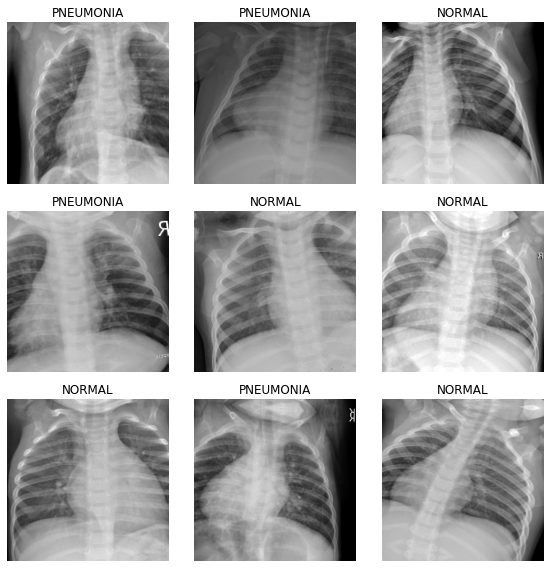

In [35]:
newImgDataBunch.show_batch(rows=3, figsize=(8,8))

In [36]:
newImgDataBunch.classes

['COVIDnSARS', 'NORMAL', 'PNEUMONIA']

In [37]:
w = torch.cuda.FloatTensor([11,2,1])

In [41]:
def getLearner():
    return Learner(newImgDataBunch, arch,
                      metrics=error_rate, callback_fns=ShowGraph,
                      loss_func=torch.nn.CrossEntropyLoss(weight=w)).to_fp16()

learner2 = getLearner()

In [87]:
learner2.load(f'/home/jfang/fastai/data/rsna/saved-models/model_1')

Learner(data=ImageDataBunch;

Train: LabelList (5302 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: ../../../../data/covid-19/chest_xray;

Valid: LabelList (654 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: ../../../../data/covid-19/chest_xray;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48

In [42]:
learner2.split(lambda m: (arch._conv_head,))
learner2.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.74E-02


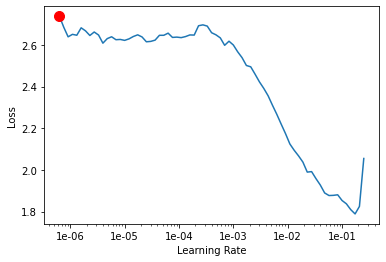

In [89]:
wd = 1e-1
learner2.lr_find(wd=wd)
learner2.recorder.plot(suggestion = True)

In [90]:
max_lr = 8e-3

epoch,train_loss,valid_loss,error_rate,time
0,0.465645,0.759303,0.272171,01:10
1,0.242170,2.641317,0.876147,01:09
2,0.208727,2.290211,0.386850,01:08
3,0.215910,2.501688,0.533639,01:09
4,0.173436,1.345357,0.383792,01:09
5,0.136271,0.513225,0.198777,01:10
6,0.114926,0.309714,0.125382,01:09
7,0.107294,0.244334,0.079511,01:09


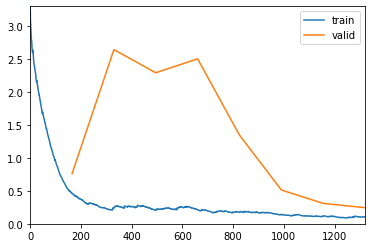

In [91]:
learner2.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)

In [92]:
interp = ClassificationInterpretation.from_learner(learner2)

losses,idxs = interp.top_losses()

len(newImgDataBunch.valid_ds)==len(losses)==len(idxs)

True

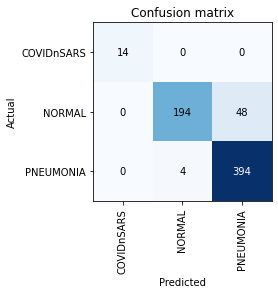

In [93]:
interp = ClassificationInterpretation.from_learner(learner2)
interp.plot_confusion_matrix()

In [94]:
#os.makedirs('/home/jfang/fastai/data/covid-19/saved-models')

In [95]:
learner2.save(f'/home/jfang/fastai/data/covid-19/saved-models/model_1', return_path = True)

PosixPath('/home/jfang/fastai/data/covid-19/saved-models/model_1.pth')

In [104]:
gc.collect()

133

In [ ]:
interp = ClassificationInterpretation.from_learner(learner2)
interp.plot_confusion_matrix()

In [49]:
learner2.load(f'/home/jfang/fastai/data/covid-19/saved-models/model_1')

Learner(data=ImageDataBunch;

Train: LabelList (5302 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: ../../../../data/covid-19/chest_xray;

Valid: LabelList (654 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: ../../../../data/covid-19/chest_xray;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48

In [50]:
learner2.loss_func=torch.nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor([11,3,1]))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-05


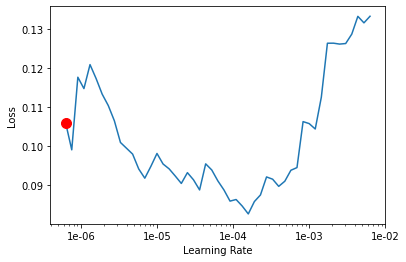

In [51]:
wd = 1e-1
learner2.unfreeze()
learner2.lr_find(wd=wd)

# plot learning rate finder results
learner2.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,error_rate,time
0,0.088232,0.233542,0.073394,01:13
1,0.090504,0.209919,0.076453,01:13
2,0.086610,0.217172,0.074924,01:13
3,0.085994,0.198492,0.068807,01:13
4,0.094291,0.200039,0.064220,01:14
5,0.086266,0.209843,0.070336,01:13
6,0.099968,0.209939,0.070336,01:13
7,0.096396,0.204140,0.070336,01:14


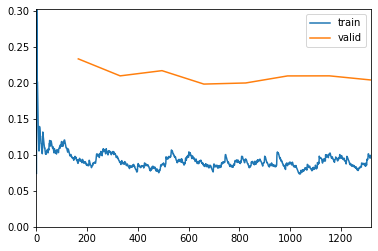

In [52]:
learner2.fit_one_cycle(cyc_len=8, max_lr=slice(1e-4))

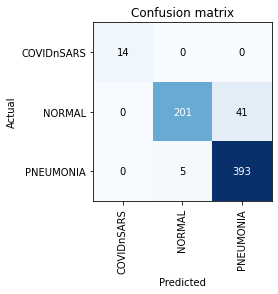

In [53]:
interp = ClassificationInterpretation.from_learner(learner2)
interp.plot_confusion_matrix()

In [116]:
learner2.save(f'/home/jfang/fastai/data/covid-19/saved-models/model_2', return_path = True)

PosixPath('/home/jfang/fastai/data/covid-19/saved-models/model_2.pth')